In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data',
                                    train=True,
                                    download=True,
                                    transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                    train=False,
                                    download=True,
                                    transform=transform)

In [4]:
train_loader = DataLoader(trainset,
                         batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                         batch_size=128,
                          shuffle=False,
                          num_workers=2)

### 이미지 출력

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

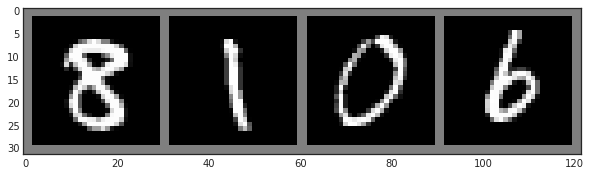

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

### 초기 모델 구성 및 학습

In [8]:
# 전체 모델 아키텍처

class Net(nn.Module):
    def __init__(self): # layer 정의
        super(Net, self).__init__()

        # input size = 28x28 
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/(100*(i/100))))

Epoch: 1, Iter: 100, Loss: 2.3253032221938623
Epoch: 1, Iter: 200, Loss: 2.3088117975685463
Epoch: 1, Iter: 300, Loss: 2.2998622412665632
Epoch: 1, Iter: 400, Loss: 2.291318380145501
Epoch: 2, Iter: 100, Loss: 2.2229298870972913
Epoch: 2, Iter: 200, Loss: 2.1493656461562343
Epoch: 2, Iter: 300, Loss: 1.9976391887983749
Epoch: 2, Iter: 400, Loss: 1.76427641115093


In [11]:
# pretrained 모델 정확도 계산
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        im, la = data
        outputs = net(im)
        _, predicted = torch.max(outputs.data, 1)
        total += la.size(0)
        correct += (predicted == la).sum().item()
    
    print(100 * correct / total)

81.17


### 학습된 초기 모델 저장

In [12]:
PATH = '/home/proj01/jungha/mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Feature extraction Layer 동결

In [15]:
def dfs_freeze(model):
    for name, child in model.named_children():
        if name == 'fc1':
            print('From here FCN')
            return
        
        for param in child.parameters():
            print(param)
            param.requires_grad = False
            print(param)
        dfs_freeze(child)

In [16]:
dfs_freeze(net)

Parameter containing:
tensor([[[[-0.4277, -0.2683, -0.2942],
          [-0.4449, -0.3554,  0.1477],
          [-0.1766,  0.2325,  0.2556]]],


        [[[ 0.2508,  0.4606, -0.0023],
          [ 0.2270,  0.2866,  0.3095],
          [-0.2388,  0.3884, -0.2533]]],


        [[[-0.2118,  0.3947,  0.4111],
          [ 0.0303, -0.1697,  0.0793],
          [ 0.1983, -0.3451, -0.3781]]],


        [[[-0.0223, -0.3011, -0.0804],
          [-0.1763,  0.0950,  0.1886],
          [-0.3314,  0.0486,  0.4371]]],


        [[[-0.1139, -0.2467,  0.5033],
          [-0.3946,  0.3454,  0.5063],
          [-0.2943,  0.5140,  0.3306]]],


        [[[-0.4738, -0.5620, -0.2921],
          [-0.5267, -0.1037, -0.1329],
          [-0.4726, -0.5746, -0.2622]]]], requires_grad=True)
Parameter containing:
tensor([[[[-0.4277, -0.2683, -0.2942],
          [-0.4449, -0.3554,  0.1477],
          [-0.1766,  0.2325,  0.2556]]],


        [[[ 0.2508,  0.4606, -0.0023],
          [ 0.2270,  0.2866,  0.3095],
          [-

### Fine tunning

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [18]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/(100*(i/100))))

Epoch: 1, Iter: 100, Loss: 0.6271142128742102
Epoch: 1, Iter: 200, Loss: 0.6108108210803276
Epoch: 1, Iter: 300, Loss: 0.6041921093113047
Epoch: 1, Iter: 400, Loss: 0.6013061448296807
Epoch: 2, Iter: 100, Loss: 0.5736285866510988
Epoch: 2, Iter: 200, Loss: 0.5703423403615329
Epoch: 2, Iter: 300, Loss: 0.5636127190446375
Epoch: 2, Iter: 400, Loss: 0.557489445110909
Epoch: 3, Iter: 100, Loss: 0.5304289038735207
Epoch: 3, Iter: 200, Loss: 0.5271450284138397
Epoch: 3, Iter: 300, Loss: 0.5239229714591368
Epoch: 3, Iter: 400, Loss: 0.520253219625406


In [19]:
# pretrained 모델 정확도 계산
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        im, la = data
        outputs = net(im)
        _, predicted = torch.max(outputs.data, 1)
        total += la.size(0)
        correct += (predicted == la).sum().item()
    
    print(100 * correct / total)

85.3


In [20]:
total_batch = len(train_loader)
print(total_batch) # 총 6만개의 데이터

469


### TRAIN LOADER 중간 결과값 저장 및 불러오기

In [21]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    output_data = F.max_pool2d(F.relu(net.conv2(F.max_pool2d(F.relu(net.conv1(inputs)), (2, 2)))), 2)
    output = output_data.data
    output_arr = output.numpy()
    target_arr = labels.numpy()
    if i == 0:
        input_arr = output_arr
        label_arr = target_arr
    else:
        input_arr = np.concatenate((input_arr, output_arr), axis=0)
        label_arr = np.concatenate((label_arr, target_arr), axis=0)

In [22]:
input_arr.shape, label_arr.shape

((60000, 16, 5, 5), (60000,))

In [23]:
np.save('./frozen_output/input_arr.npy', input_arr)
np.save('./frozen_output/label_arr.npy', label_arr)

In [5]:
frozen_input_arr = np.load('./frozen_output/input_arr.npy')
frozen_label_arr = np.load('./frozen_output/label_arr.npy')

In [6]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(frozen_input_arr) # transform to torch tensor
tensor_y = torch.Tensor(frozen_label_arr).type(torch.LongTensor)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2) # create your dataloader

In [7]:
len(my_dataloader) # 동일한 개수의 배치 개수 가짐

469

### TEST LOADER 중간 결과값 저장 및 불러오기

In [27]:
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    output_data = F.max_pool2d(F.relu(net.conv2(F.max_pool2d(F.relu(net.conv1(inputs)), (2, 2)))), 2)
    output = output_data.data
    output_arr = output.numpy()
    target_arr = labels.numpy()
    if i == 0:
        input_arr2 = output_arr
        label_arr2 = target_arr
    else:
        input_arr2 = np.concatenate((input_arr2, output_arr), axis=0)
        label_arr2 = np.concatenate((label_arr2, target_arr), axis=0)

In [28]:
input_arr2.shape, label_arr2.shape

((10000, 16, 5, 5), (10000,))

In [29]:
np.save('./frozen_output/input_arr_test.npy', input_arr2)
np.save('./frozen_output/label_arr_test.npy', label_arr2)

In [8]:
input_arr_test = np.load('./frozen_output/input_arr_test.npy')
label_arr_test = np.load('./frozen_output/label_arr_test.npy')

In [9]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x2 = torch.Tensor(input_arr_test) # transform to torch tensor
tensor_y2 = torch.Tensor(label_arr_test).type(torch.LongTensor)

my_dataset2 = TensorDataset(tensor_x2,tensor_y2) # create your datset
my_test_dataloader = DataLoader(my_dataset2,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2) # create your dataloader

In [10]:
len(my_test_dataloader), len(test_loader) # 동일한 개수의 배치 개수 가짐

(79, 79)

### Classifie-Only Model 선언 및 Weight load

In [11]:
class TF_NET(nn.Module):
    def __init__(self):
        super(TF_NET, self).__init__()
         
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
trainable_model = TF_NET()

In [13]:
PATH = '/home/proj01/jungha/mnist_net.pth'
state_dict = torch.load(PATH)

with torch.no_grad():
    trainable_model.fc1.weight.copy_(state_dict['fc1.weight'])
    trainable_model.fc1.bias.copy_(state_dict['fc1.bias'])
    trainable_model.fc2.weight.copy_(state_dict['fc2.weight'])
    trainable_model.fc2.bias.copy_(state_dict['fc2.bias'])
    trainable_model.fc3.weight.copy_(state_dict['fc3.weight'])
    trainable_model.fc3.bias.copy_(state_dict['fc3.bias'])

In [14]:
trainable_model

TF_NET(
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### FCN만 가지고 있는 모델의 Fine tunning 결과

In [16]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(trainable_model.parameters(), lr=0.0001, momentum=0.9)

In [17]:
def dfs_unfreeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            print(param)
            param.requires_grad = True
            print(param)
        dfs_unfreeze(child)

In [18]:
dfs_unfreeze(trainable_model)

Parameter containing:
tensor([[-0.0082,  0.0433,  0.0060,  ...,  0.0416, -0.0514,  0.0385],
        [ 0.0131, -0.0068, -0.0418,  ..., -0.0318, -0.0436,  0.0219],
        [ 0.0087, -0.0043,  0.0239,  ...,  0.0034, -0.0077, -0.0165],
        ...,
        [-0.0438,  0.0256,  0.0276,  ...,  0.0258,  0.0436, -0.0282],
        [-0.0165, -0.0468, -0.0475,  ...,  0.0196, -0.0006, -0.0268],
        [ 0.0374, -0.0164, -0.0184,  ..., -0.0465, -0.0394,  0.0426]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0082,  0.0433,  0.0060,  ...,  0.0416, -0.0514,  0.0385],
        [ 0.0131, -0.0068, -0.0418,  ..., -0.0318, -0.0436,  0.0219],
        [ 0.0087, -0.0043,  0.0239,  ...,  0.0034, -0.0077, -0.0165],
        ...,
        [-0.0438,  0.0256,  0.0276,  ...,  0.0258,  0.0436, -0.0282],
        [-0.0165, -0.0468, -0.0475,  ...,  0.0196, -0.0006, -0.0268],
        [ 0.0374, -0.0164, -0.0184,  ..., -0.0465, -0.0394,  0.0426]],
       requires_grad=True)
Parameter containing:
tensor([ 1.1

In [38]:
for param in trainable_model.parameters():
    param.requires_grad = True

In [19]:
for epoch in range(3):
    trainable_model.train()
    
    running_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        inputs, labels = data
        optimizer2.zero_grad()
        
        outputs = trainable_model(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/(100*(i/100))))

Epoch: 1, Iter: 100, Loss: 0.6081923478179507
Epoch: 1, Iter: 200, Loss: 0.6074820436424946
Epoch: 1, Iter: 300, Loss: 0.6030623903840681
Epoch: 1, Iter: 400, Loss: 0.5984515182505873
Epoch: 2, Iter: 100, Loss: 0.578211027865458
Epoch: 2, Iter: 200, Loss: 0.5685347077535026
Epoch: 2, Iter: 300, Loss: 0.563524951603899
Epoch: 2, Iter: 400, Loss: 0.5571737721898502
Epoch: 3, Iter: 100, Loss: 0.5386847137200712
Epoch: 3, Iter: 200, Loss: 0.5315125677453812
Epoch: 3, Iter: 300, Loss: 0.528131251749785
Epoch: 3, Iter: 400, Loss: 0.5234011507273318


### Frozen Model과 simliar한 결과값

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in my_test_dataloader:
        im, la = data
        outputs = trainable_model(im)
        _, predicted = torch.max(outputs.data, 1)
        total += la.size(0)
        correct += (predicted == la).sum().item()

    print(100 * correct / total)

85.3
